## **IMPORT PACKAGES**

In [157]:
from itertools import product
from scipy import stats 
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind, f_oneway
from scipy.stats import levene
from scipy.stats import pearsonr 
from scipy.stats import norm 
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pandas.api.types import is_numeric_dtype
from math import radians, cos, sin, asin, sqrt
from datetime import datetime
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, average_precision_score 
from yellowbrick.model_selection import LearningCurve

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import optuna
import shap
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.precision', 4)
pd.set_option('display.float_format', '{:,.4}'.format)
sns.set_style('darkgrid')
plt.rc('figure', figsize = (18,6))
plt.rc('font', family = 'sans-serif')

## **DATA CLEANING AND PREPROCESSING**

In [2]:
df1 = pd.read_csv('train.csv')
df_train = df1.copy()
df2 = pd.read_csv('test.csv')
df_test = df2.copy()

### **Data Cleaning**

In [3]:
df_train['Weatherconditions'].unique()

array(['conditions Sunny', 'conditions Stormy', 'conditions Sandstorms',
       'conditions Cloudy', 'conditions Fog', 'conditions Windy',
       'conditions NaN'], dtype=object)

In [4]:
# drop two redundant columns 'ID' and 'Delivery_person_ID' from df_train and df_test
df_train.drop(columns=['ID','Delivery_person_ID'],inplace=True)
df_test.drop(columns=['ID','Delivery_person_ID'],inplace=True)

# convert datatype to numeric 
df_train['Delivery_person_Age'] = pd.to_numeric(df_train['Delivery_person_Age'], 
                                                errors='coerce')
df_test['Delivery_person_Age'] = pd.to_numeric(df_test['Delivery_person_Age'], 
                                                errors='coerce')

df_train['Delivery_person_Ratings']=pd.to_numeric(df_train['Delivery_person_Ratings'],
                                                  errors='coerce')
df_test['Delivery_person_Ratings']=pd.to_numeric(df_test['Delivery_person_Ratings'],
                                                  errors='coerce')

df_train['multiple_deliveries']=pd.to_numeric(df_train['multiple_deliveries'],
                                              errors='coerce')
df_test['multiple_deliveries']=pd.to_numeric(df_test['multiple_deliveries'],
                                             errors='coerce')

# substitute the entries in the 'Weatherconditions' feature with more succinct values, and then convert any occurrences of 'NaN' represented as strings to null data types.
df_train['Weatherconditions']=df_train['Weatherconditions'].str.replace('conditions ','')\
                                                               .replace('NaN',np.nan)
df_test['Weatherconditions']=df_test['Weatherconditions'].str.replace('conditions ','')\
                                                             .replace('NaN',np.nan)

# transform any occurences of 'NaN' represented as strings into null datatype
df_train['Road_traffic_density']=df_train['Road_traffic_density'].str.strip().replace('NaN',np.nan)
df_test['Road_traffic_density']=df_test['Road_traffic_density'].str.strip().replace('NaN',np.nan)

df_train['Festival']=df_train['Festival'].str.strip().replace('NaN',np.nan)
df_test['Festival']=df_test['Festival'].str.strip().replace('NaN',np.nan)

df_train['City']=df_train['City'].str.strip().replace('NaN',np.nan)
df_test['City']=df_test['City'].str.strip().replace('NaN',np.nan)

# remove leading and trailing whitespace from a value.
df_train['Type_of_order']=df_train['Type_of_order'].str.strip()
df_test['Type_of_order']=df_test['Type_of_order'].str.strip()

df_train['Type_of_vehicle']=df_train['Type_of_vehicle'].str.strip()
df_test['Type_of_vehicle']=df_test['Type_of_vehicle'].str.strip()

# remove unnecessary expression and convert it to float datatype
df_train['Time_taken(min)']=df_train['Time_taken(min)'].str.strip('(min) ').astype(float)


In [5]:
# 'set_frame_style' function sets style and title for dataframe
def set_frame_style(df,caption=''):
  return df.style\
          .set_caption(caption)\
          .set_table_styles([{
            'selector':'caption',
            'props':[('color','White'),('font-size','16px'),
                     ('font-weight','bold'),('text-align','left')]}])
# 'fontdict' function set fontsize and fontweight:
def fontdict(fontsize=20, fontweight='bold'):
  return {'fontsize':fontsize, 'fontweight':fontweight}
# 'check_data' function creates dataframes containing information about a given dataset.

#### **Data Preprocessing**

1. Handle Missing Values

<AxesSubplot: >

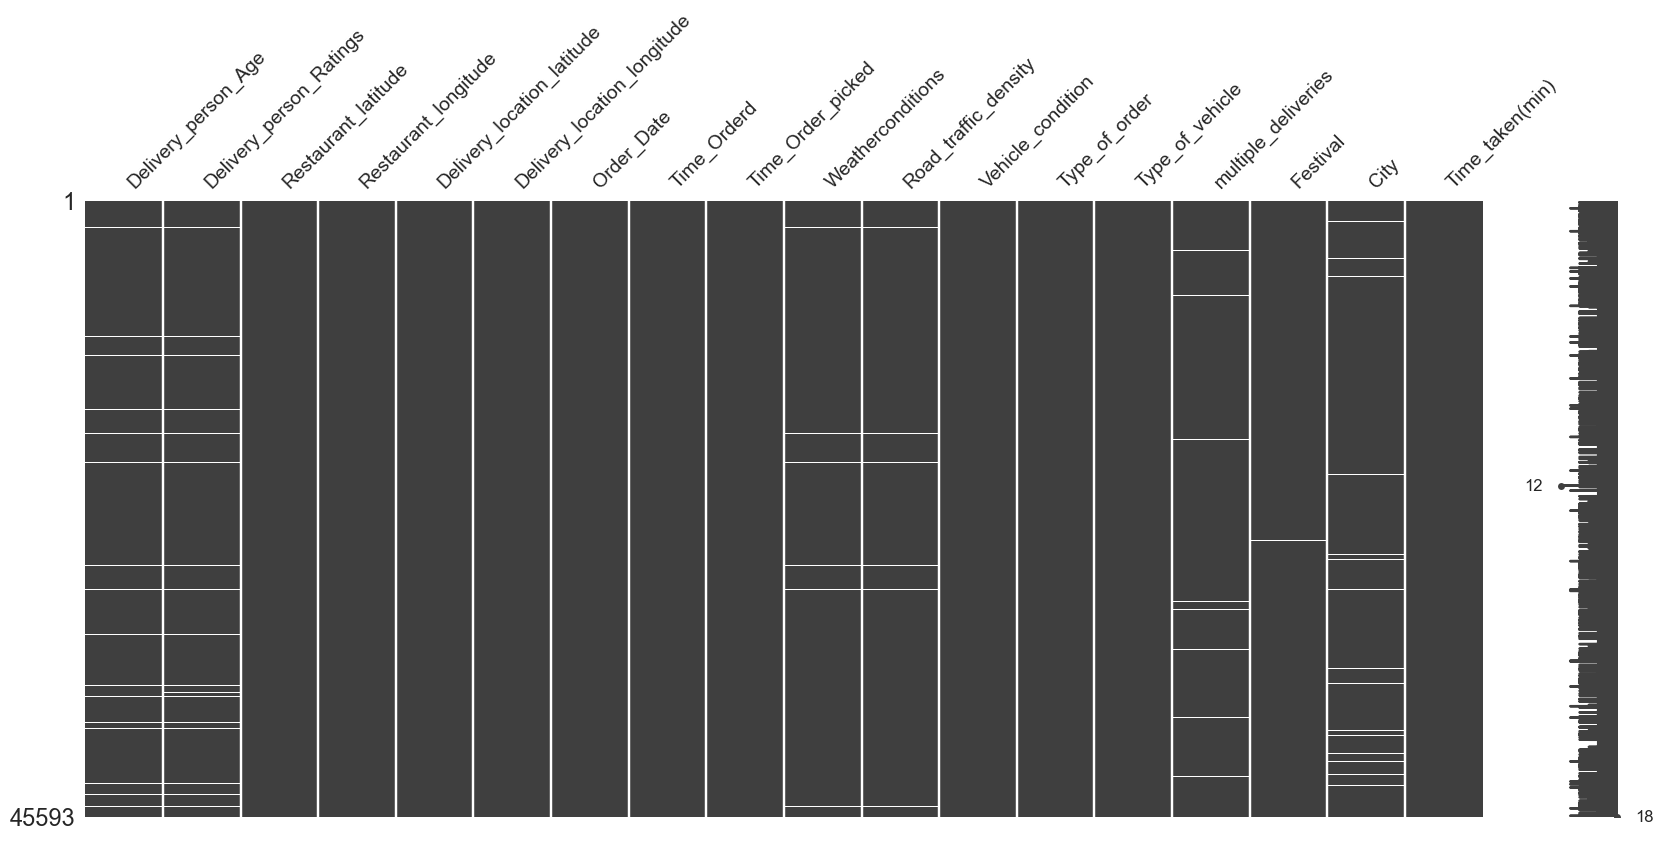

In [6]:
# plot matrix using library missingno (msno)
msno.matrix(df_train,figsize=(20,8),fontsize=14)


We can see patterns here, let's check the percentage of missing values in whole data set, if it is not significantly large, we will just drop data points that have null values

In [7]:
cols=df_train.columns[df_train.isnull().any()].tolist()

#compute the percentages of missing values for each feature
train_null_percentage_col = df_train[cols].isnull().sum()/df_train.size * 100
test_null_percentage_col = df_test[cols].isnull().sum()/df_test.size * 100

#create the dataframes showing percentages of missing values for each feature
df_null_percentage_col = pd.concat([train_null_percentage_col, test_null_percentage_col], 
                                   axis=1,keys=['Training data','Testing data'])

#compute the percentages of missing values of the entire datasets
train_null_percentage=df_train.isnull().sum().sum()/df_train.size * 100
test_null_percentage=df_test.isnull().sum().sum()/df_test.size*100

#create a series showing percentages of missing values of the entire datasets
df_null_percentage=pd.Series([train_null_percentage,test_null_percentage],index=['Training data','Testing data'])\
                              .to_frame('Null Percentage')
display(set_frame_style(df_null_percentage_col,  'NULL percentages for each feature'))
display(set_frame_style(df_null_percentage, 'NULL percentages regarding the entire dataset'))

,Training data,Testing data
Delivery_person_Age,0.225912,0.253376
Delivery_person_Ratings,0.232492,0.261633
Weatherconditions,0.075060,0.081534
Road_traffic_density,0.073232,0.079470
multiple_deliveries,0.120998,0.122818
Festival,0.027782,0.033543
City,0.146221,0.167197


,Null Percentage
Training data,0.901698
Testing data,0.999572


With just 1% of null values in the entire dataset, it is generally reasonable to drop those null values, as they won't significantly affect the overall analysis or modeling process. 

In [8]:
df_train=df_train.dropna()
df_test=df_test.dropna()

In [9]:
# Create bins for a continuous feature 'Delivery_person_Age' and use them as categorical variables in a machine learning model,
# the model will treat each bin as a separate category. 
df_train['Delivery_person_Age_Range']=pd.cut(df_train['Delivery_person_Age'],
                                             bins=[19,25,30,35,40],
                                             labels=['20-25','26-30','31-35','36-40'])
df_test['Delivery_person_Age_Range']=pd.cut(df_test['Delivery_person_Age'],
                                            bins=[19,25,30,35,40],
                                            labels=['20-25','26-30','31-35','36-40'])



Introduce a new feature named 'Distance' computed from the longtitudes and latitudes of restaurants and delivery location to represent the spatial distance between two locations.

In [10]:
# a function to compute the distance 
def distance(df, lat1, lat2, lon1, lon2):

  lon1_rad = df[lon1].apply(radians)
  lon2_rad = df[lon2].apply(radians)
  lat1_rad = df[lat1].apply(radians)
  lat2_rad = df[lat2].apply(radians)

  dlon = lon2_rad - lon1_rad
  dlat = lat2_rad - lat1_rad

  a = dlat.apply(lambda x: sin(x/2)**2 )\
                            + lat1_rad.apply(cos) \
                            * lat2_rad.apply(cos) \
                            * dlon.apply(lambda x: sin(x/2) ** 2)

  c = a.apply(lambda x: asin(sqrt(x)))*2
  
  r = 6371

  return round(c*r,2)
# a function to insert column into a dataframe in an wanted position
def insert_column_in_order(df,col,value,new_col=[]):
  if new_col in df.columns:
    return df
  
  else:
    return df.insert(loc = df_train.columns.get_loc(col) + 1, 
                     column = new_col, value = value)

distance_train = distance(df_train, 'Restaurant_latitude','Delivery_location_latitude',
                                    'Restaurant_longitude','Delivery_location_longitude')
distance_test = distance(df_test, 'Restaurant_latitude','Delivery_location_latitude',
                                  'Restaurant_longitude','Delivery_location_longitude')

insert_column_in_order(df_train,'Delivery_location_longitude',
                       new_col = 'Distance (km)',value = distance_train)
insert_column_in_order(df_test,'Delivery_location_longitude',
                       new_col = 'Distance (km)',value = distance_test)

In [11]:
# a function converting datetime into day
def convert_to_day(df,col):
  return pd.to_datetime(df[col],format='%d-%m-%Y').dt.strftime('%A')
# a function converting an entry's data type into datetime datatype
def convert_to_datetime_type(df,col):
  return pd.to_datetime(df[col],format='%H:%M:%S')

def convert_to_time_of_day(df,col):
  bins = [0,6,12,18,24]
  labels = ['Night','Morning','Afternoon','Evening']
  return pd.cut(df[col], bins = bins, labels = labels, include_lowest = True)

#create new feature giving information about the day of week
day_train = convert_to_day(df_train,'Order_Date')
day_test = convert_to_day(df_test,'Order_Date')

insert_column_in_order(df_train,'Order_Date',
                       new_col='Weekday',value=day_train)
insert_column_in_order(df_test,'Order_Date',
                       new_col='Weekday',value=day_test)

# We have extracted useful information from the feature 'Order_Date'. 
# In addition, the problem in this project is by no means related to time series.
# Therefore, we can safely drop the redundant column 'Order_Date'
df_train=df_train.drop(columns='Order_Date')

#create new feature which gives information about the time of the day in hour unit
Time_Orderd_Hour_Train = convert_to_datetime_type(df_train,'Time_Orderd').dt.hour
Time_Orderd_Hour_Test = convert_to_datetime_type(df_test,'Time_Orderd').dt.hour

insert_column_in_order(df_train,'Time_Order_picked',
                       new_col='Time_Orderd_Hour',value=Time_Orderd_Hour_Train)
insert_column_in_order(df_test,'Time_Order_picked',
                       new_col='Time_Orderd_Hour',value=Time_Orderd_Hour_Test)

#create new feature giving information about the duration of the delivery in minute unit
Orderd_Picked_Duration_Train = (convert_to_datetime_type(df_train,'Time_Order_picked')\
                                - convert_to_datetime_type(df_train,'Time_Orderd')).dt.seconds/60
Orderd_Picked_Duration_Test = (convert_to_datetime_type(df_test,'Time_Order_picked')\
                               - convert_to_datetime_type(df_test,'Time_Orderd')).dt.seconds/60

#convert the datatype for 'Time_Ordered_Hour': from object datatype to datetime datatype
Time_Of_Day_Train = convert_to_time_of_day(df_train, 'Time_Orderd_Hour')
Time_Of_Day_Test = convert_to_time_of_day(df_test, 'Time_Orderd_Hour' )

insert_column_in_order(df_train,'Time_Orderd_Hour',
                       new_col='Time_Of_Day',value=Time_Of_Day_Train)
insert_column_in_order(df_test,'Time_Orderd_Hour',
                       new_col='Time_Of_Day',value=Time_Of_Day_Test)

insert_column_in_order(df_train,'Time_Order_picked',
                       new_col='Orderd_Picked_Duration_Train',value=Orderd_Picked_Duration_Train)
insert_column_in_order(df_test,'Time_Order_picked',
                       new_col='Orderd_Picked_Duration_Train',value=Orderd_Picked_Duration_Test)

#drop 2 redundant columns as we already captured useful information from them
df_train = df_train.drop(columns = ['Time_Orderd','Time_Order_picked'])

# 'Metropolitian' is basically the same as 'Urban', so we can substitute all of entries having word 'Metropolitian' with 'Urban'.
# The same for 'Jam' and 'High'
df_train['City'] = df_train['City'].replace('Metropolitian','Urban')
df_test['City'] = df_test['City'].replace('Metropolitian','Urban')

df_train['Road_traffic_density'] = df_train['Road_traffic_density'].replace('Jam','High')
df_test['Road_traffic_density'] = df_test['Road_traffic_density'].replace('Jam','High')

The dataset now becomes:


In [12]:
display(set_frame_style(df_train.head(5),
                        caption=f'First 5 Rows of New Training Data'))

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
0,37.000000,4.900000,22.745049,75.892471,22.765049,75.912471,3.030000,Saturday,15.000000,11,Morning,Sunny,High,2,Snack,motorcycle,0.000000,No,Urban,24.000000,36-40
1,34.000000,4.500000,12.913041,77.683237,13.043041,77.813237,20.180000,Friday,5.000000,19,Evening,Stormy,High,2,Snack,scooter,1.000000,No,Urban,33.000000,31-35
2,23.000000,4.400000,12.914264,77.678400,12.924264,77.688400,1.550000,Saturday,15.000000,8,Morning,Sandstorms,Low,0,Drinks,motorcycle,1.000000,No,Urban,26.000000,20-25
3,38.000000,4.700000,11.003669,76.976494,11.053669,77.026494,7.790000,Tuesday,10.000000,18,Afternoon,Sunny,Medium,0,Buffet,motorcycle,1.000000,No,Urban,21.000000,36-40
4,32.000000,4.600000,12.972793,80.249982,13.012793,80.289982,6.210000,Saturday,15.000000,13,Afternoon,Cloudy,High,1,Snack,scooter,1.000000,No,Urban,30.000000,31-35


In [14]:
print(f"Training dataset's shape: {df_train.shape}")
print(f"Testing dataset's shape: {df_test.shape}")

Training dataset's shape: (41368, 21)
Testing dataset's shape: (10291, 23)


In [15]:
df_train.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Distance (km)', 'Weekday',
       'Orderd_Picked_Duration_Train', 'Time_Orderd_Hour', 'Time_Of_Day',
       'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition',
       'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival',
       'City', 'Time_taken(min)', 'Delivery_person_Age_Range'],
      dtype='object')

Which features are categorical?
- Categorical features are the values nominal, ordinal based. In addition, Categorical features have a limited number of unique values. 
- Categorical: 'Weekday','Orderd_Picked_Duration_Train', 'Time_Of_Day', 'Weatherconditions','Road_traffic_density','Vehicle_condition','Type_of_order','Type_of_vehicle','multiple_deliveries','Festival','City','Delivery_person_Age_Range'

Which features are continuously numerical?
- Continuous: 'Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude','Delivery_location_latitude', 'Delivery_location_longitude', 'Distance (km)'
Which is target variable?
-target variable: 'Time_taken(min)'

In [16]:
# assign a target variable column name to a variable for later use
target_col='Time_taken(min)'

cat_cols = ['Weekday','Orderd_Picked_Duration_Train', 'Time_Of_Day', 
            'Weatherconditions','Road_traffic_density','Vehicle_condition',
            'Type_of_order','Type_of_vehicle','multiple_deliveries','Festival',
            'City','Delivery_person_Age_Range']

df_train[cat_cols]= df_train[cat_cols].astype('object')

# assign names of numerical features to num_cols for later use
continuous_cols=df_train.select_dtypes(include='number').columns\
                                                 .drop(target_col).to_list()



In [17]:

def check_data(df, title):
  display(set_frame_style(df.head(), 
                          caption=f'{title}: First 5 rows'))
  display(set_frame_style(df.describe(include='number'),
                          caption=f'{title}: Descriptive Statistic Of Numeric Values'))
  display(set_frame_style(df.describe(include='object'),
                          caption=f'{title}: Descriptive Statistic Of Categorical Values'))
  display(set_frame_style(df.nunique().to_frame('UNIQUE COUNT').transpose(),
                          caption=f'Unique Value Count'))

In [18]:
check_data(df_train, 'TRAIN SET')


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
0,37.000000,4.900000,22.745049,75.892471,22.765049,75.912471,3.030000,Saturday,15.000000,11,Morning,Sunny,High,2,Snack,motorcycle,0.000000,No,Urban,24.000000,36-40
1,34.000000,4.500000,12.913041,77.683237,13.043041,77.813237,20.180000,Friday,5.000000,19,Evening,Stormy,High,2,Snack,scooter,1.000000,No,Urban,33.000000,31-35
2,23.000000,4.400000,12.914264,77.678400,12.924264,77.688400,1.550000,Saturday,15.000000,8,Morning,Sandstorms,Low,0,Drinks,motorcycle,1.000000,No,Urban,26.000000,20-25
3,38.000000,4.700000,11.003669,76.976494,11.053669,77.026494,7.790000,Tuesday,10.000000,18,Afternoon,Sunny,Medium,0,Buffet,motorcycle,1.000000,No,Urban,21.000000,36-40
4,32.000000,4.600000,12.972793,80.249982,13.012793,80.289982,6.210000,Saturday,15.000000,13,Afternoon,Cloudy,High,1,Snack,scooter,1.000000,No,Urban,30.000000,31-35


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Time_Orderd_Hour,Time_taken(min)
count,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000,41368.000000
mean,29.610013,4.633209,17.254366,70.777471,17.472437,70.841351,26.912076,17.436569,26.553350
std,5.764152,0.315861,7.691357,21.122080,7.337077,21.122283,298.782065,4.793826,9.334363
min,20.000000,2.500000,-30.902872,0.000000,0.010000,0.010000,1.470000,0.000000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.989096,73.279083,4.660000,15.000000,19.000000
50%,30.000000,4.700000,18.554382,75.898497,18.636258,76.002471,9.270000,19.000000,26.000000
75%,35.000000,4.900000,22.732225,78.046106,22.785536,78.107097,13.740000,21.000000,33.000000
max,39.000000,5.000000,30.914057,88.433452,31.054057,88.563452,6884.730000,23.000000,54.000000


,Weekday,Orderd_Picked_Duration_Train,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Delivery_person_Age_Range
count,41368,41368.000000,41368,41368,41368,41368,41368,41368,41368.000000,41368,41368,41368
unique,7,3.000000,4,6,3,3,4,3,4.000000,2,2,4
top,Wednesday,5.000000,Evening,Fog,High,0,Meal,motorcycle,1.000000,No,Urban,20-25
freq,6466,13858.000000,21639,7116,17262,13925,10421,24300,26176.000000,40535,41216,12146


,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Distance (km),Weekday,Orderd_Picked_Duration_Train,Time_Orderd_Hour,Time_Of_Day,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Delivery_person_Age_Range
UNIQUE COUNT,20,26,487,389,4361,4361,408,7,3,17,4,6,3,3,4,3,4,2,2,45,4


### **Exploration Data Analysis**

#### **Univariate Analysis**
When performing univariate analysis, we are usually interested in analysing one or more variables in dataset individually

Let's plot histograms to see continuous features' distributions 

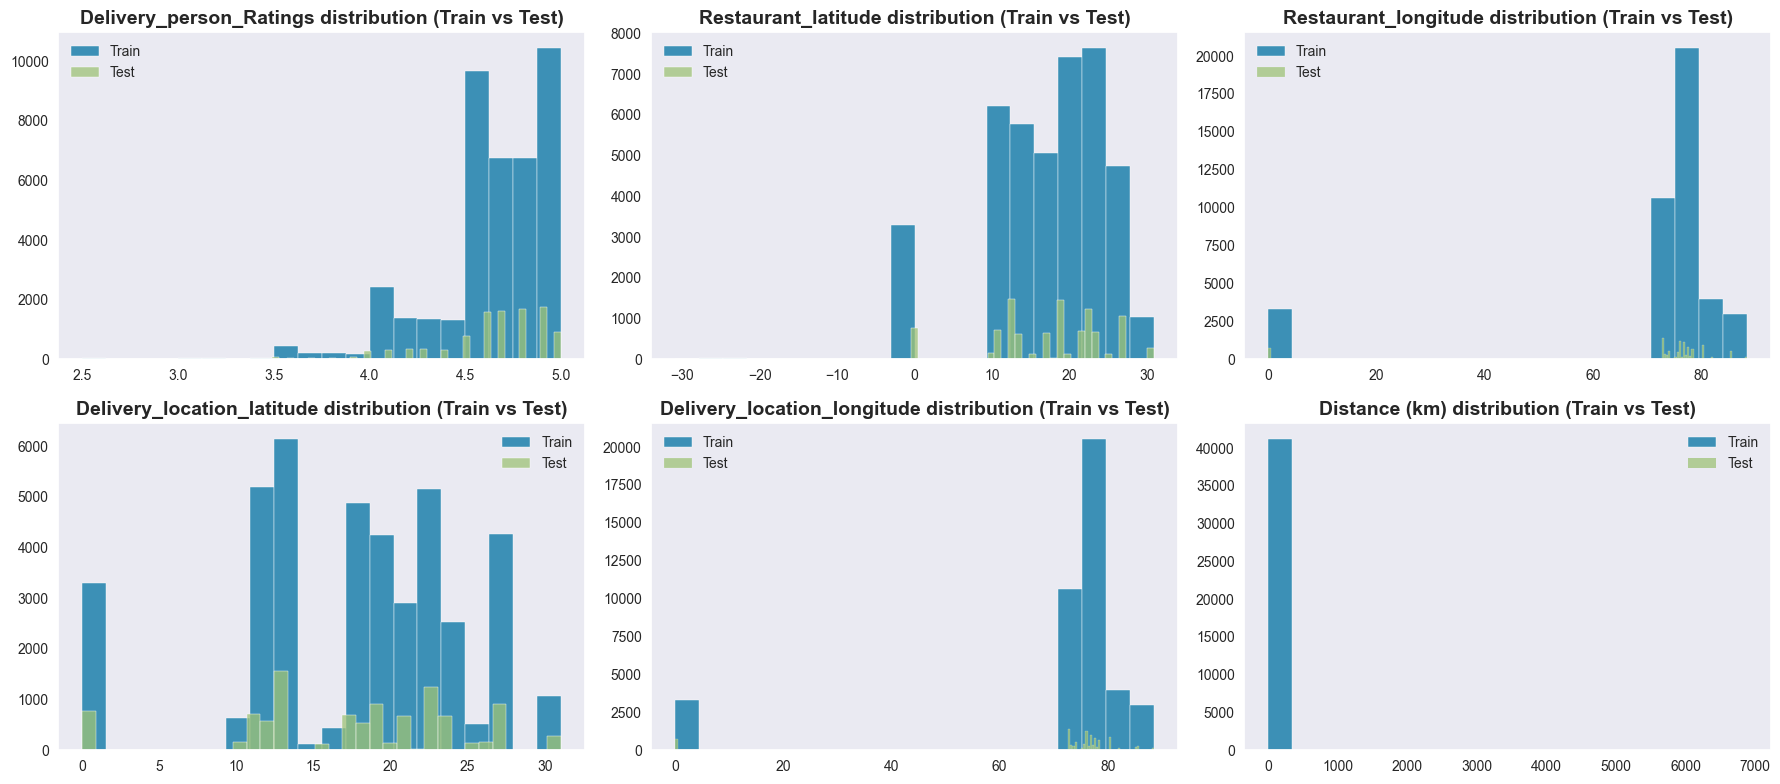

,mean,std,min,max,skewness,median
Delivery_person_Ratings,4.633209,0.315861,2.500000,5.000000,-1.781582,4.700000
Restaurant_latitude,17.254366,7.691357,-30.902872,30.914057,-1.055635,18.554382
Restaurant_longitude,70.777471,21.122080,0.000000,88.433452,-2.955469,75.898497
Delivery_location_latitude,17.472437,7.337077,0.010000,31.054057,-0.703192,18.636258
Delivery_location_longitude,70.841351,21.122283,0.010000,88.563452,-2.955461,76.002471
Distance (km),26.912076,298.782065,1.470000,6884.730000,18.269177,9.270000


In [19]:
continuous_cols = ['Delivery_person_Ratings', 'Restaurant_latitude', 
                   'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude',
                   'Distance (km)']
fig, axes= plt.subplots(2,3, figsize=(18,8))
axes= axes.flatten()
for i, col_name in enumerate(continuous_cols):
    ax = axes[i]
    sns.histplot(df_train[col_name], kde=False,
                  ax=ax, label='Train',bins=20)
    sns.histplot(df_test[col_name], kde=False, 
                 ax=ax, label='Test')
    ax.set_title(f'{col_name} distribution (Train vs Test)', 
                 fontdict = fontdict(14))
    ax.legend()
    ax.grid(False)
    ax.set_ylabel(None)
    ax.set_xlabel(None)
plt.tight_layout()
plt.show()

skewness = df_train[continuous_cols].skew()
median = df_train[continuous_cols].median()
descrip_table=df_train[continuous_cols].describe().\
                  transpose()[['mean','std','min','max']]
descrip_table['skewness'] = skewness
descrip_table['median'] = median

display(set_frame_style(descrip_table))

As depicted above, features 'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude', and 'Delivery_person_Ratings'are negatively skewed, indicating that the majority of observations are clustered towards higher values, with a tail extending towards the lower end of the scale. Meanwhile, the 'Distance (km)' is positively skewed. It seems that there are a lot of outliers in the dataset. However, i will dive deeper into outlier detection later on

Although Box-Cox (including log) transformations are generally effective for achieving normality, they often introduce complexities in interpretation. At this point, I'm still in the process of exploring the data and determining the statistical methods or models suitable for the dataset. Therefore, I plan to postpone normalization and outlier detections until later stages of the project, when its necessity becomes clearer

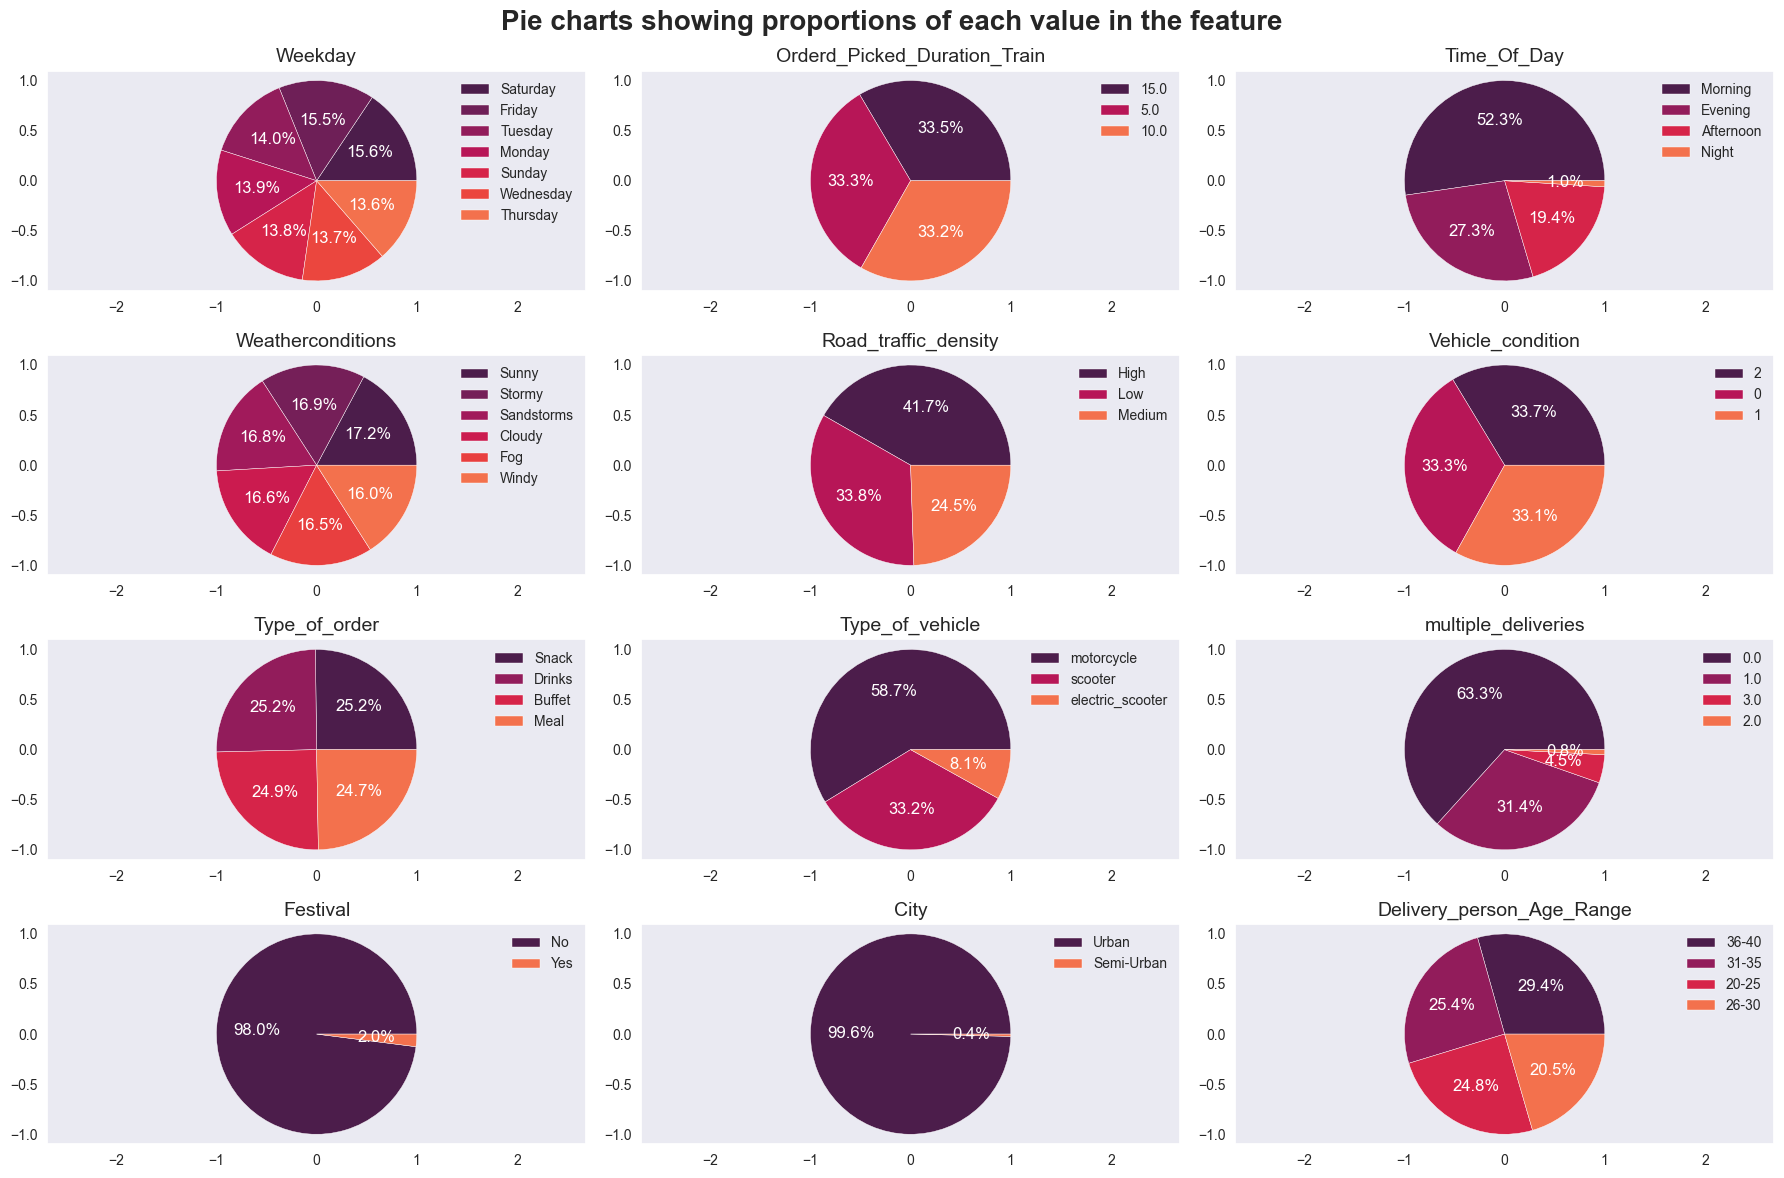

,count,unique,top,freq
Weekday,41368,7,Wednesday,6466
Orderd_Picked_Duration_Train,41368.000000,3.000000,5.000000,13858.000000
Time_Of_Day,41368,4,Evening,21639
Weatherconditions,41368,6,Fog,7116
Road_traffic_density,41368,3,High,17262
Vehicle_condition,41368,3,0,13925
Type_of_order,41368,4,Meal,10421
Type_of_vehicle,41368,3,motorcycle,24300
multiple_deliveries,41368.000000,4.000000,1.000000,26176.000000
Festival,41368,2,No,40535


In [20]:
fig, axes= plt.subplots(nrows=4,ncols=3, figsize=(18,12))
axes= axes.flatten()
for i, col_name in enumerate(cat_cols):
      ax = axes[i]
      colors = plt.get_cmap()(np.linspace(0.2, 0.7, len(df_train[col_name].unique())))
      ax.pie(df_train[col_name].value_counts(), 
             autopct='%1.1f%%', colors=colors, 
             frame=True, textprops={'color': "white"})
      ax.set_title(f'{col_name}', fontdict=fontdict(14,'medium'))
      ax.grid(False)
      ax.axis('equal')
      ax.legend(df_train[col_name].unique(), loc='best')
fig.suptitle('Pie charts showing proportions of each value in the feature', fontsize=20, fontweight='bold')
plt.tight_layout()
plt.show()

descrip_table = df_train[cat_cols].describe().transpose()

display(set_frame_style(descrip_table))



### **Bivariate analysis**
When performing bivariate analysis, we are interested in how two variables are distributed or related. 

#### **Continous variable vs Continuous variable**

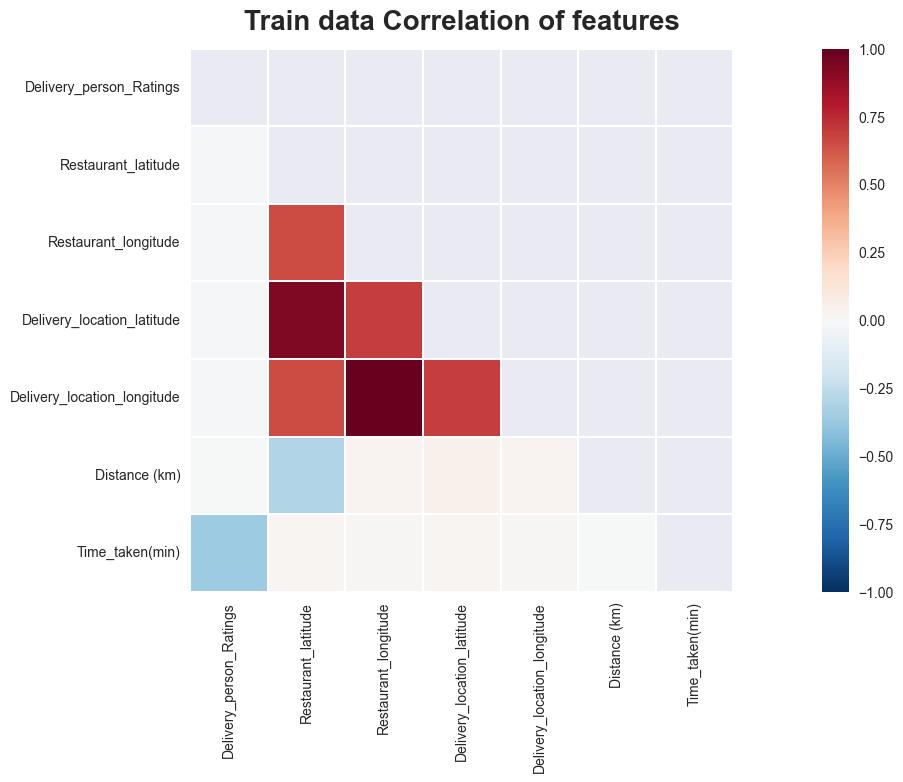

In [21]:

def plot_heatmap(df,title):
  mask = np.zeros_like(df.astype(float).corr())
  mask[np.triu_indices_from(mask)] =True 
  # set the colormap and figure size 
  colormap = plt.cm.RdBu_r
  plt.figure(figsize=(18,8))
  plt.title(f'{title } Correlation of features', fontdict=fontdict(), y= 1.02)
  #plot the heatmap with the masked diagonal elements
  plt.grid(False)
  sns.heatmap(df.astype(float).corr(),linewidths=0.1, 
              vmax=1.0,vmin=-1.0, 
              square=True, cmap=colormap,linecolor='white',
              annot=False, annot_kws={'size':14, 'weight':'bold'},mask=mask)
  plt.tight_layout()
plot_heatmap(df_train[continuous_cols + [target_col]], title='Train data')



As shown above, the Restaurant_latitude and Delivery_location_latitude, Restaurant_longitude and Delivery_location_longitude are highly correlated. 

Restaurant_latitude and Delivery_location_latitude, as well as Restaurant_longitude and Delivery_location_longitude, being highly correlated makes sense in the context of food delivery services for several reasons:
- Usually, restaurants choose locations within a certain geographic area to serve. Similarly, delivery services operate within specific regions or zones. Hence, the latitude and logitude coordinates of both the restaurant and delivery locations would naturally be correlated because they operate within the same or overlapping geographic areas
- Restaurants tend to locate themselves where there's a demand for their services (delivery locations)

In spite of the strong correlation between such variables, we can not draw conclusions regarding causual effect of them on each other.


The heatmap above did not reveal any strong associations between the target variable and the continuous features included in the analysis.

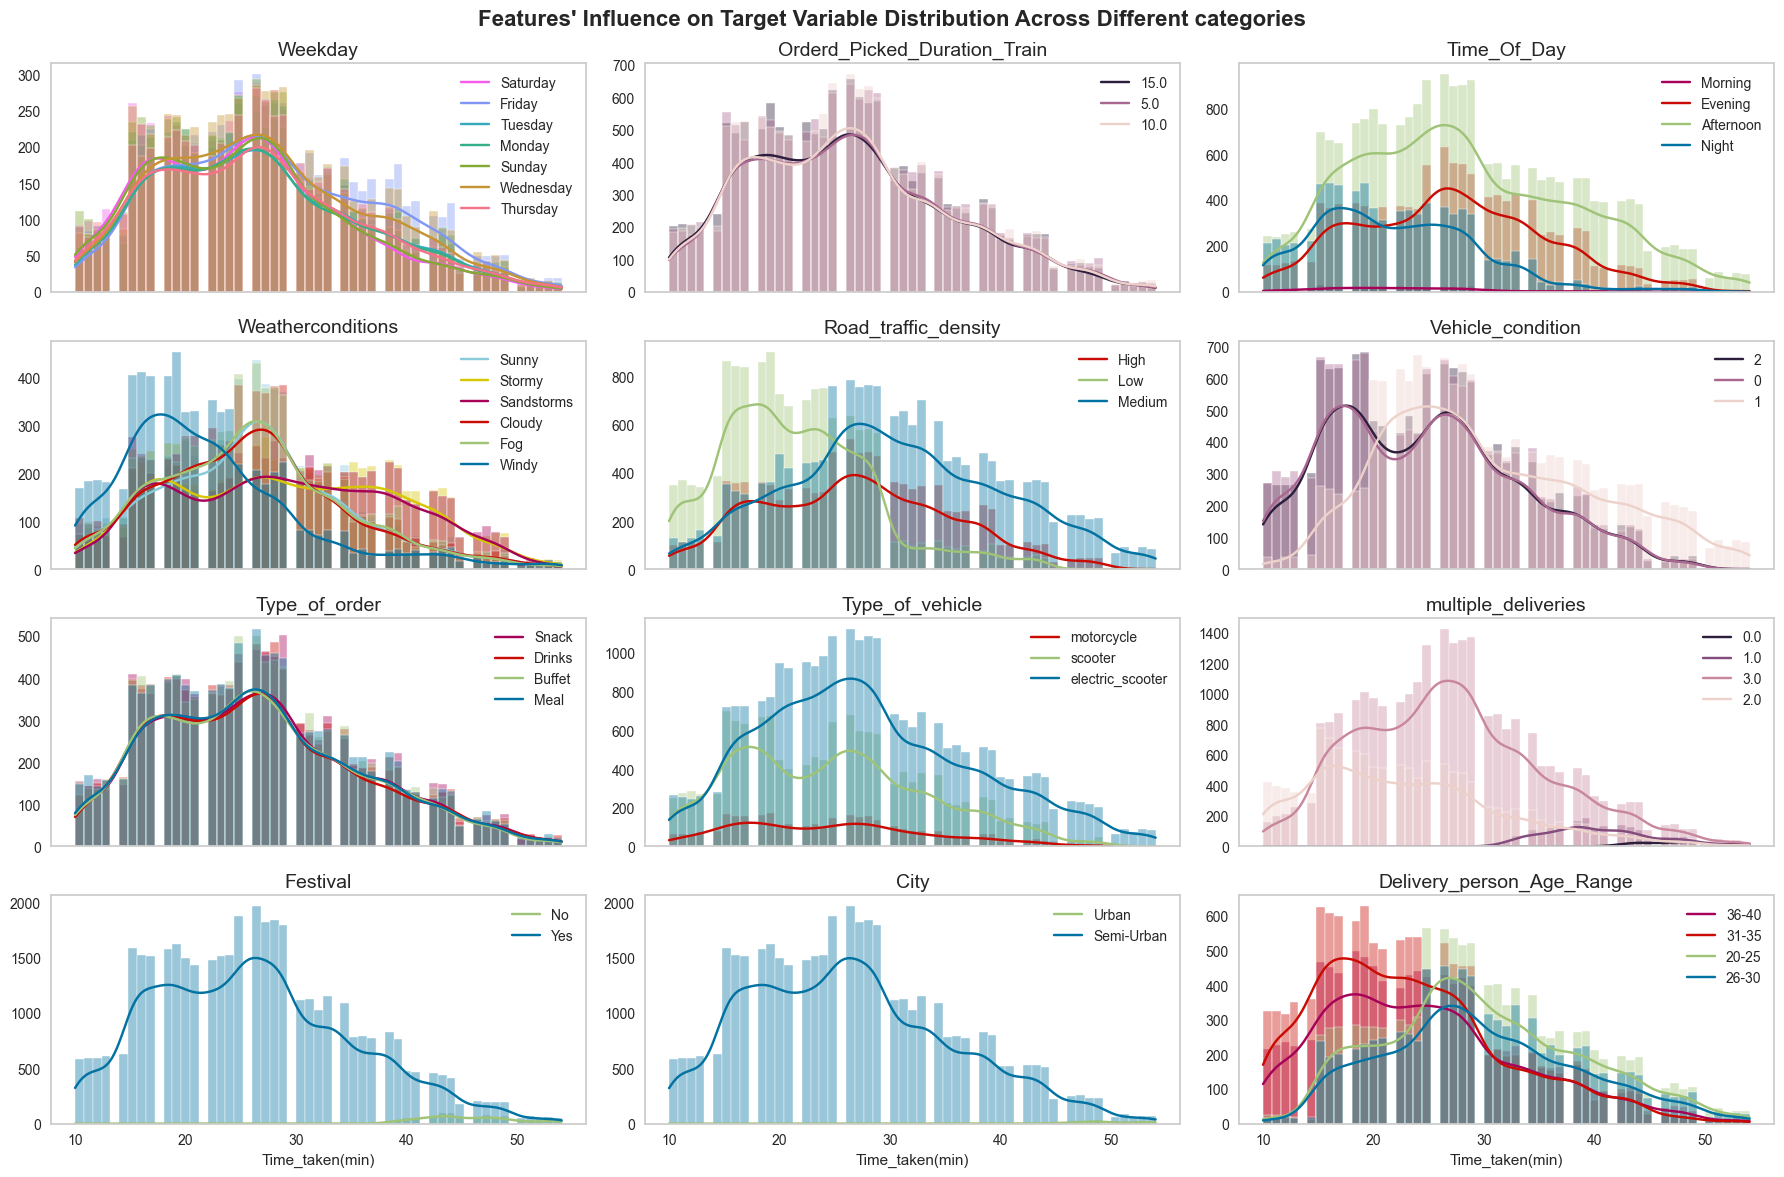

In [23]:
sns.set_style('whitegrid')
n_cols=3
fig,axes= plt.subplots(figsize=(18,12), nrows=4, 
                       ncols=3, sharex=True)

axes=axes.flatten() 

for i, cat_col in enumerate(cat_cols):
    ax=axes[i]
    sns.histplot(data=df_train, x=target_col, 
                 hue=cat_col, kde=True, ax=ax, alpha=0.4)
    ax.set_title(f'{cat_col}',fontsize=14)
    ax.grid(False)
    ax.legend( df_train[cat_col].unique(),loc='best')
    ax.set_ylabel(None)
fig.suptitle(f"Features' Influence on Target Variable Distribution Across Different categories",
              fontweight='bold', fontsize=16)
plt.tight_layout()
plt.show()



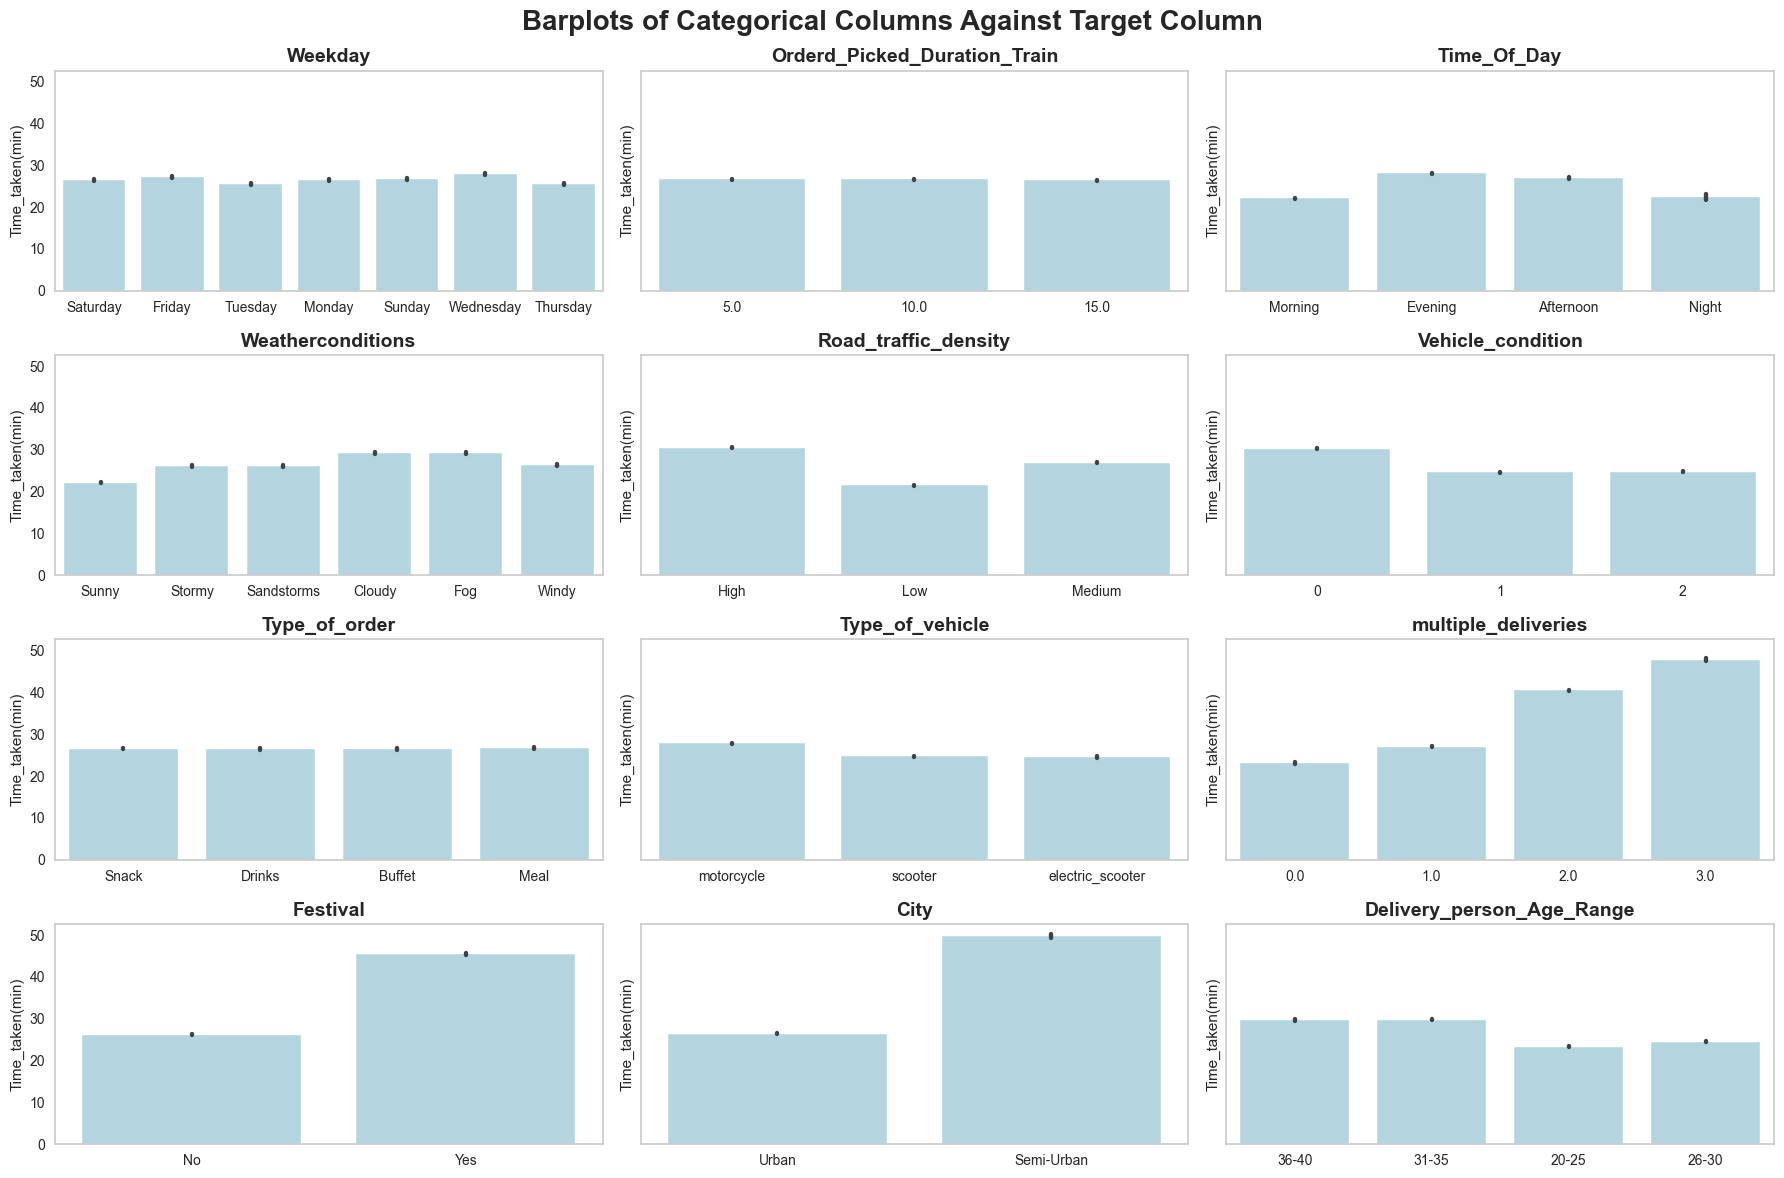

In [52]:
n_cols=3
fig,axes= plt.subplots(figsize=(18,12), 
                       nrows=4, ncols=3, sharey=True)

axes=axes.flatten() 

for i, cat_col in enumerate(cat_cols):
    ax=axes[i]
    sns.barplot(data=df_train, x=cat_col, 
                y=target_col,ax=ax, color='lightblue')
    ax.set_title(f'{cat_col}',fontdict=fontdict(14))
    ax.grid(False)
    ax.set_xlabel(None)
    
fig.suptitle(f"Barplots of Categorical Columns Against Target Column",
              fontweight='bold', fontsize=20)
plt.tight_layout()
plt.show()



From the two graphs above, we can observe that the means of time_taken for deliveries considerably vary among the categories of 'Festival', 'City', 'Delivery_person_Age_Range', 'Road_traffic_density'. However, I will need perform statistical techniques to test whether these differences are statistically significant 

Most statistical testing techniques require the sample to be randomly normally distributed. Therefore, I will now normalize each feature (if necessary) step by step and then conduct statistical testing for each of them

First, let's examine categorical variables that have only two categories, in which we can conduct a t-test to determine if there is any significant difference between the categories. 

1. Festival 

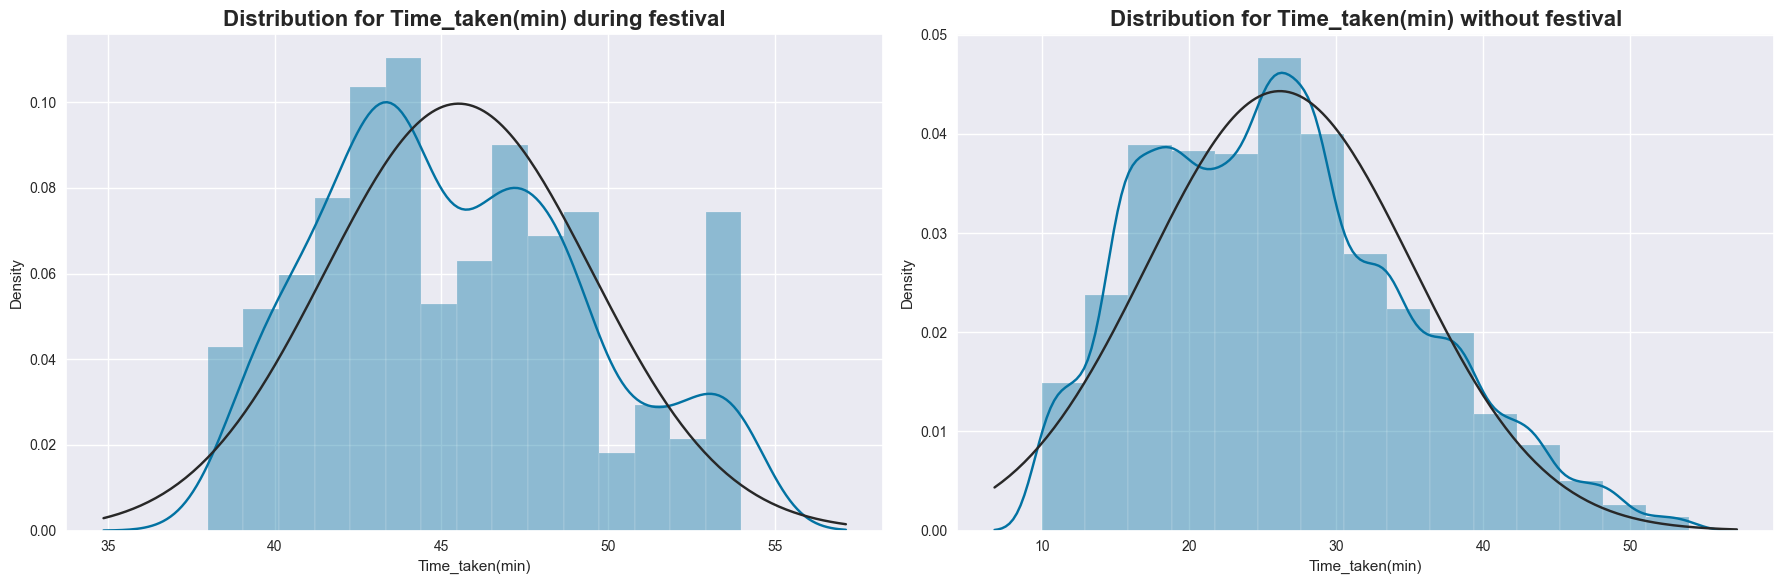

In [78]:
no_festival = df_train[df_train['Festival']=='No'][target_col]
yes_festival = df_train[df_train['Festival']=='Yes'][target_col]

fig, (ax1, ax2 )= plt.subplots(1,2,sharey=False)
sns.distplot(yes_festival, fit=norm, ax=ax1, kde=True, bins= 15)
sns.distplot( no_festival,fit=norm, ax=ax2, kde= True, bins=15)

ax1.set_title(f'Distribution for {target_col} during festival', fontdict=fontdict(16))
ax2.set_title(f'Distribution for {target_col} without festival', fontdict=fontdict(16))

plt.tight_layout()

The two samples appear to be approximately normally distributed. However, if our samples does not follow normal distribution, we can still use t-test as our sample size is larger than 30. The t-test is known to be robust to violations of normality assumption, particularly for large sample sizes

now, let's perform t-test

In [105]:
statistic, p_value = ttest_ind(no_festival, yes_festival)
print('Test Statistic:', statistic)
print('p-value', p_value)
alpha=0.05
if p_value < alpha:
  print('Reject the null hypothesis: \n At significance level 5%, there is enough evidence to support \n that there is significant difference between the means of two samples')
else:
  print('Fail to the null hypothesis: \nAt significance level 5%,  there is not enough evidence to support \n that there is significant difference between the means of two samples')

Test Statistic: -61.92395814797769
p-value 0.0
Reject the null hypothesis: 
 At significance level 5%, there is enough evidence to support 
 that there is significant difference between the means of two samples


2. City

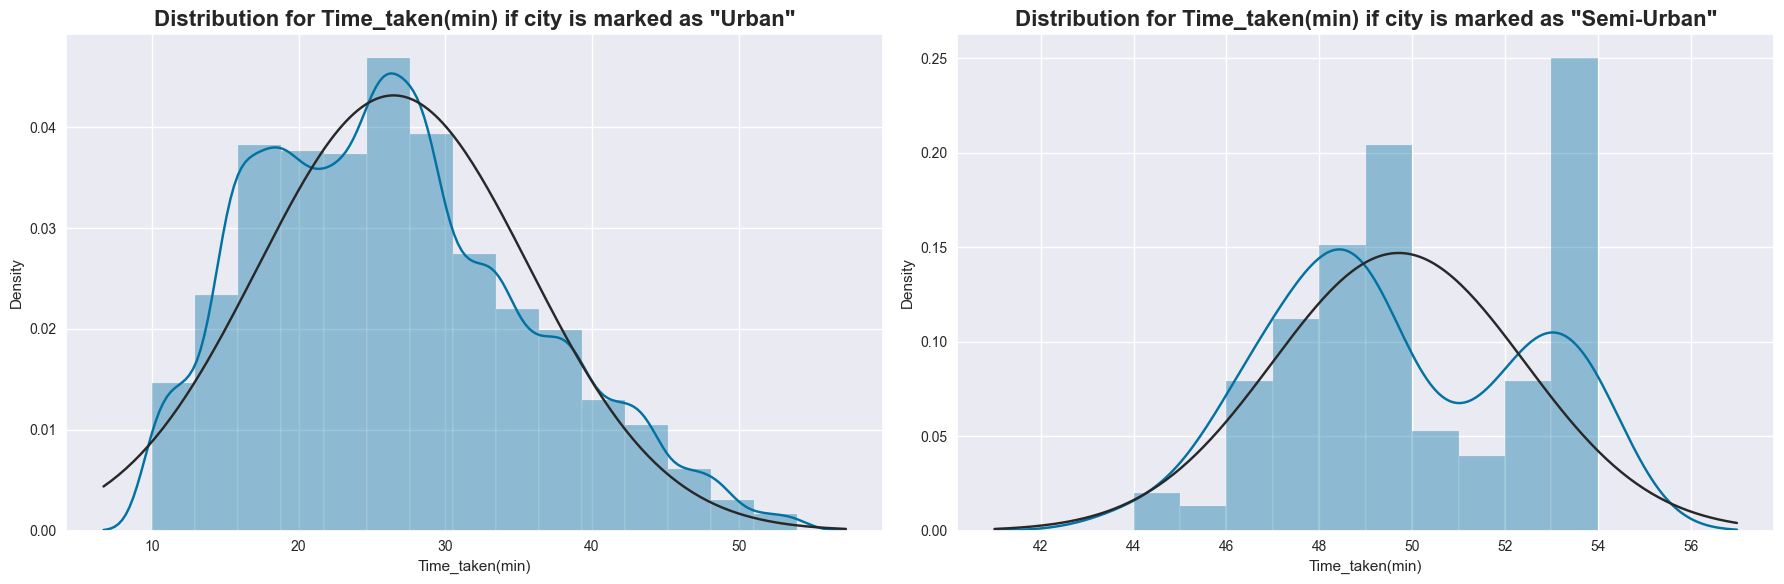

In [97]:
urban = df_train[df_train['City']=='Urban'][target_col]
semi_urban = df_train[df_train['City']=='Semi-Urban'][target_col]

fig, (ax1, ax2 )= plt.subplots(1,2,sharey=False)
sns.distplot(urban, fit=norm, ax=ax1, kde=True, bins= 15)
sns.distplot( semi_urban,fit=norm, ax=ax2, kde= True, bins=10)

ax1.set_title(f'Distribution for {target_col} if city is marked as "Urban"', fontdict=fontdict(16))
ax2.set_title(f'Distribution for {target_col} if city is marked as "Semi-Urban"', fontdict=fontdict(16))

plt.tight_layout()

In [104]:
statistic, p_value = ttest_ind(no_festival, yes_festival)
print('Test Statistic:', statistic)
print('p-value', p_value)
alpha=0.05
if p_value < alpha:
  print('Reject the null hypothesis: \n At significance level 5%, there is enough evidence to support \n that there is significant difference between the means of two samples')
else:
  print('Fail to the null hypothesis: \nAt significance level 5%,  there is not enough evidence to support \n that there is significant difference between the means of two samples')
  

Test Statistic: -61.92395814797769
p-value 0.0
Reject the null hypothesis: 
 At significance level 5%, there is enough evidence to support 
 that there is significant difference between the means of two samples


Now let's move on categorical features that have more than 2 categories. 

For such categorical features, I will perform one-way analysis of variance test (one-way anova). For this test, the samples must be selected from a normal or appoximately normal population

Let's examine the distribution using boxplot

1. Weekday

<AxesSubplot: xlabel='Weekday', ylabel='Time_taken(min)'>

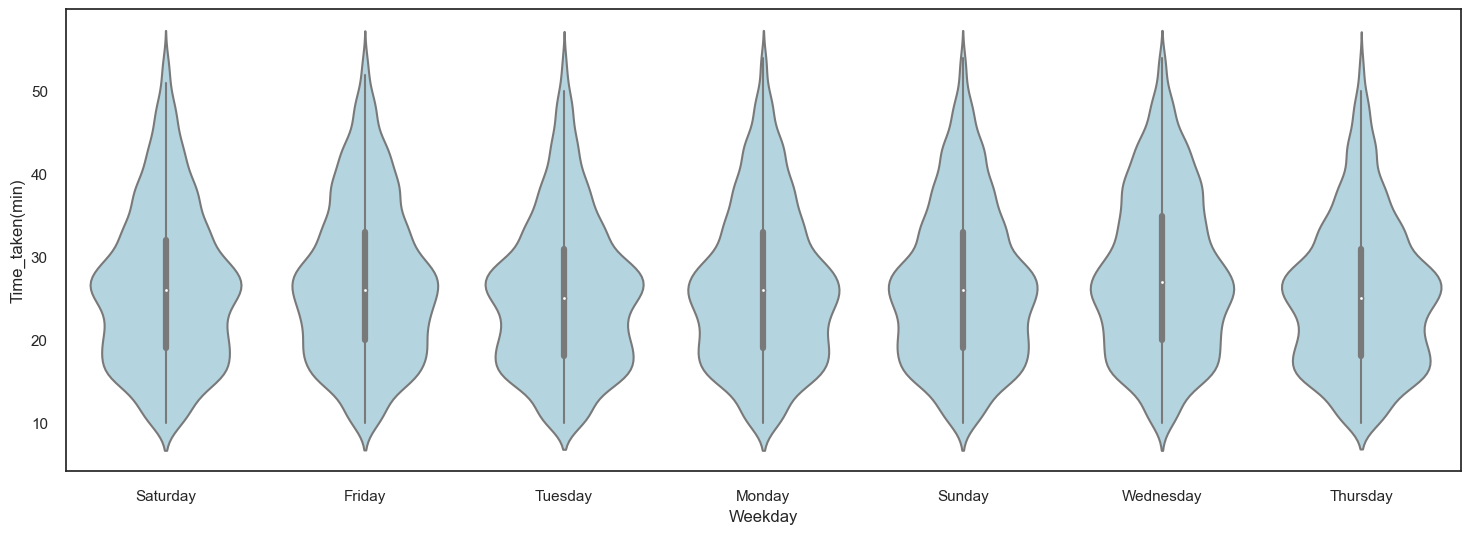

In [154]:
sns.violinplot(data=df_train, x='Weekday', y=target_col, color='lightblue')


As illustrated above, the distributions exhibit characteristics that resemble those of a normal distribution. Consequently, i will proceed to conduct a one-way ANOVA test on the feature

For this test, the null hypothesis is that there is no two means different from each other. 

In [171]:
def one_way_Anova_and_post_hoc_test(df, categorical_col, target_col, caption=''):
  values_for_each_group = [df[df[categorical_col]==cat][target_col] \
                           for cat in df[categorical_col].unique()]
  statistic, p_value = f_oneway(*values_for_each_group)
  result = pd.DataFrame({'Feature':categorical_col,'F_score':[statistic],'p_value':[p_value]}) 

  if p_value < 0.05:
    print('Reject the null hypothesis.\
          \nAt a significance level of 5%, there is enough evidence to conclude that\
          \nthere exists a statistically significant difference among the means of at least two groups\
          ')
    display(set_frame_style(result,caption=caption))
    posthoc = pairwise_tukeyhsd(df[target_col],df[categorical_col],alpha=0.05)
    print(posthoc)
  else:
      return result
one_way_Anova_and_post_hoc_test(df_train, 'Weekday', target_col)
  

Reject the null hypothesis.          
At a significance level of 5%, there is enough evidence to conclude that          
there exists a statistically significant difference among the means of at least two groups          


,Feature,F_score,p_value
0,Weekday,52.323916,0.000000


   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------------------------
  Friday    Monday  -0.6314 0.0038 -1.1325 -0.1303   True
  Friday  Saturday  -0.7029 0.0007 -1.2025 -0.2032   True
  Friday    Sunday  -0.5025 0.0482 -1.0029 -0.0021   True
  Friday  Thursday  -1.6479    0.0 -2.1461 -1.1497   True
  Friday   Tuesday  -1.5313    0.0 -2.0289 -1.0336   True
  Friday Wednesday   0.8429    0.0  0.3594  1.3264   True
  Monday  Saturday  -0.0715 0.9996  -0.587  0.4441  False
  Monday    Sunday   0.1289 0.9903 -0.3873  0.6451  False
  Monday  Thursday  -1.0164    0.0 -1.5306 -0.5023   True
  Monday   Tuesday  -0.8999    0.0 -1.4135 -0.3863   True
  Monday Wednesday   1.4743    0.0  0.9745  1.9742   True
Saturday    Sunday   0.2004 0.9132 -0.3144  0.7152  False
Saturday  Thursday   -0.945    0.0 -1.4577 -0.4322   True
Saturday   Tuesday  -0.8284    0.0 -1.3406 -0.3162   True
Saturday Wedne

In the post-hoc test, the null hypothesis is that the paired means are equivalent. Rejecting this null hypothesis indicates a significant difference between the two means.

As illustrated in the table above, most paired categories exhibit equal means, except for the pairs (Monday, Saturday),(Monday, Sunday), (Saturday, Sunday).

It is reasonable that there is no discernible difference in the mean between Saturday and Sunday. As weekends, both days share similar characteristics that could influence delivery times in a same way. 

In [175]:
import joypy

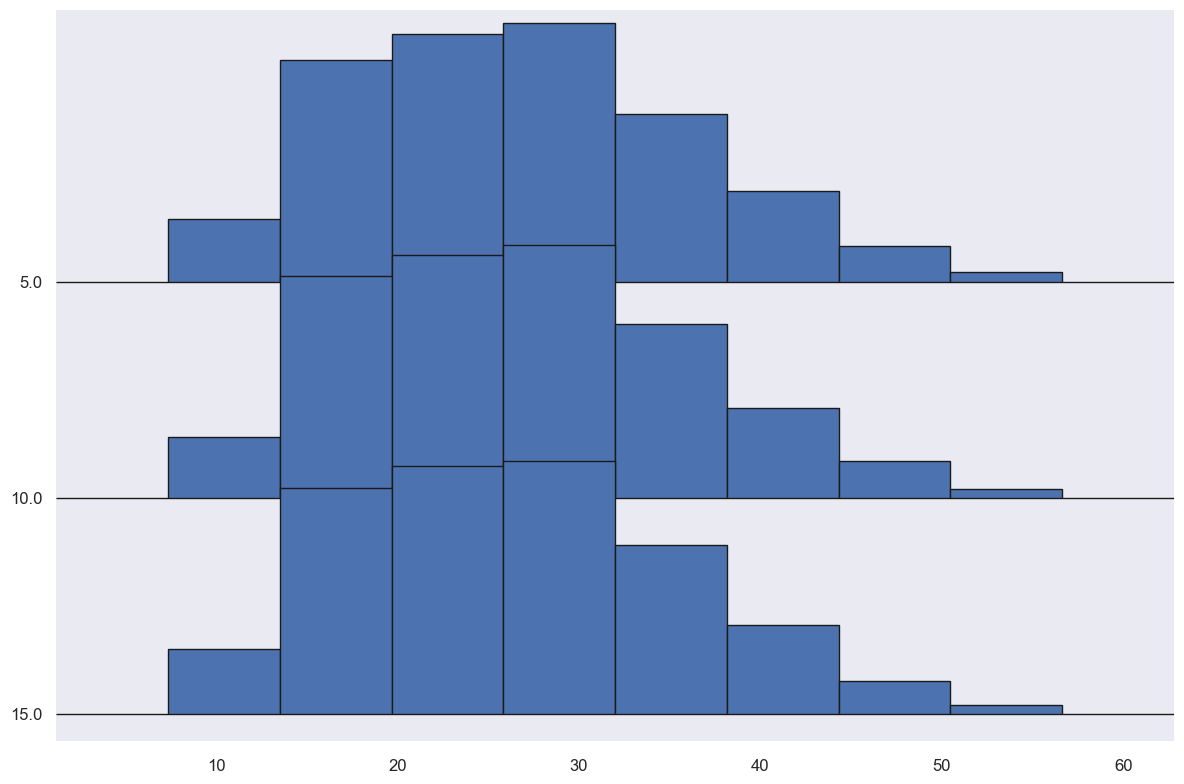

In [179]:
sns.histplot(x='target_Col', hue=)

<AxesSubplot: xlabel='Orderd_Picked_Duration_Train', ylabel='Time_taken(min)'>

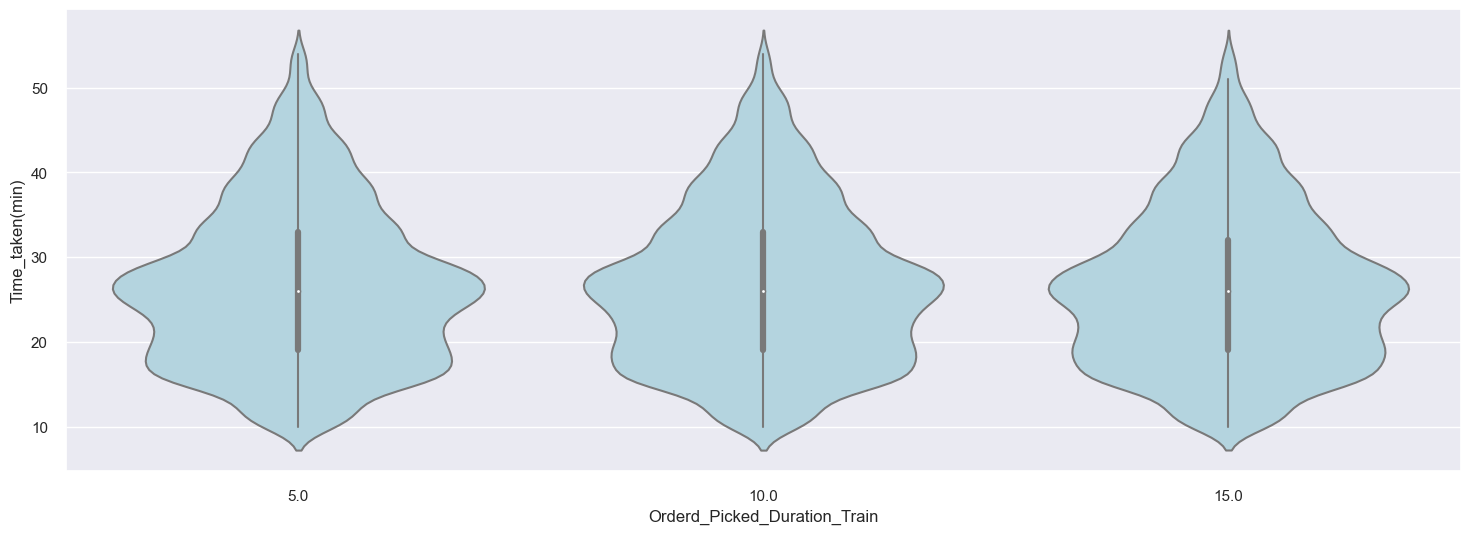

In [174]:
sns.violinplot(data=df_train, x='Orderd_Picked_Duration_Train', y=target_col, color='lightblue')


In [173]:
df_train.columns

Index(['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Distance (km)', 'Weekday',
       'Orderd_Picked_Duration_Train', 'Time_Orderd_Hour', 'Time_Of_Day',
       'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition',
       'Type_of_order', 'Type_of_vehicle', 'multiple_deliveries', 'Festival',
       'City', 'Time_taken(min)', 'Delivery_person_Age_Range'],
      dtype='object')

#### **Multivariate analysis**


#### **Outlier Detection**
**Impact of the outlier**: Outlies can change the results of the data analysis and statistical modeling. Following are some impacts of outliers in the data set:
- It may cause a significant impact on the mean and the standard deviation
- If the outliers are non-randomly distributed, they can decrease normality
- They can bias or influence estimates that may be of substantive interest
- They can also impact the basic assumption of Regression, ANOVA and other statitical model assumptions.

**Outlier detection techniques**: There are a wide range of ways to detect outliers.

Let's plot the kernel density estimation (KDE) ( a non-parametric way to estimate the probability density function)

In [ ]:
plt.figure(figsize=(16,8))
sns.set_theme(style='ticks')
sns.displot(df_train, x = target_col,kind='kde')
plt.title(f'kernel density estimation for {target_col}', fontdict=fontdict(16))
plt.grid(False)
plt.tight_layout()


#### 1 - Statistical Methods


In [ ]:
df_train.columns

In [ ]:
def remove_outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3 - q1 
  upper_boundary = q3 + 1.5*iqr 
  lower_boundary = q3 - 1.5*iqr
  new_df = df.loc[(df[col]>lower_boundary)&(df[col]<upper_boundary)]
  return new_df

In [ ]:
df_train['Distance (km)'].hist(bins=60,figsize=(10,4),grid=False)

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(16,7))
df_train = remove_outliers(df_train, 'Distance (km)')
df_test = remove_outliers(df_test, 'Distance (km)')
df_train['Distance (km)'].hist(bins=60,figsize=(10,4), ax=axes[0])
sns.boxplot(data=df_train, y='Distance (km)', ax=axes[1],showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue", "markersize":"5"})
plt.show()




## Further Analysis

In [ ]:
age_time_mean= df_train.groupby('Delivery_person_Age_Range')[['Time_taken(min)','Delivery_person_Ratings']].mean().reset_index()
age_time_mean


In [ ]:
def plot_line(df,tuple_features, axes_one=None,ax_one=None,ncols=0,nrows=0):
   if isinstance(tuple_features,list):   
      fig, axes = plt.subplots(nrows, ncols, figsize=(20,nrows*5))
      
      axes = axes.flatten()
      for i, tuple in enumerate(tuple_features):
         for x, y in [tuple]:
            ax = axes[i]
            sns.lineplot(x=x,y=y,data=df,palette='Blues', ax=ax)
            ax.set_title(f'Relationship between {x} and {y}',fontsize=16)
            ax.grid(False)
   else:
      if ax_one == None:
         sns.lineplot(x=tuple_features[0],y=tuple_features[1],data=df,palette='Blue')
         plt.title(f'Relationship between {tuple_features[0]} and {tuple_features[1]}')
         plt.grid(False)

         plt.show()

      else: 
         sns.lineplot(x=tuple_features[0],y=tuple_features[1],data=df,color='Blue', ax=axes_one[ax_one])

   
  
def plot_boxplot(df,tuple_features,ncols=0,nrows=0, axes_one=None,ax_one= None,showfliers=False, showmeans=True):
   if isinstance(tuple_features,list):   
      fig, axes = plt.subplots(nrows, ncols, figsize=(20,nrows*5))
      
      axes = axes.flatten()
      for i, tuple in enumerate(tuple_features):
         for x, y in [tuple]:
            ax = axes[i]
            sns.boxplot(x=x,y=y,data=df,palette='Blues', ax=ax, showfliers=showfliers,showmeans=showmeans, meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
            ax.set_title(f'Relationship between {x} and {y}',fontsize=16)
            ax.grid(False)
   else:
      if ax_one==None:
         sns.boxplot(x=tuple_features[0],y=tuple_features[1],data=df,showfliers=showfliers,palette='Blues',showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"})
         plt.title(f'Relationship between {tuple_features[0]} and {tuple_features[1]}')
         plt.grid(False)
      else:
         sns.boxplot(x=tuple_features[0],y=tuple_features[1],data=df,showfliers=showfliers,palette='Blues',showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"}, ax=axes_one[ax_one])




plot_line(age_time_mean,[('Delivery_person_Age_Range','Time_taken(min)'),('Delivery_person_Age_Range','Delivery_person_Ratings')],nrows=1,ncols=2)
            
plot_boxplot(df_train, [('Delivery_person_Age_Range','Time_taken(min)'),('Delivery_person_Age_Range','Delivery_person_Ratings')],nrows=1,ncols=2,showfliers=True)
   



We can see that at the age increast the time increase and the rate discrease, now use statistical testing to check whether there are truly differences between 4 age  or just a due to chance group using anova. But before being able to use anova we need to remove outliers to fulfill the normality assumptions 

In [ ]:
age_time_taken_removed_outliers_df = df_train.groupby('Delivery_person_Age_Range').apply(lambda f: remove_outliers(f, 'Time_taken(min)')).reset_index(drop=True)
age_ratings_taken_removed_outliers_df = df_train.groupby('Delivery_person_Age_Range').apply(lambda f: remove_outliers(f, 'Delivery_person_Ratings')).reset_index(drop=True)

age_time_taken_removed_outliers_df.groupby('Delivery_person_Age_Range').apply(lambda f: plot_boxplot(f,('Delivery_person_Age_Range', 'Time_taken(min)')))


In [ ]:
time_taken_for_each_age_group = [age_time_taken_removed_outliers_df[age_time_taken_removed_outliers_df['Delivery_person_Age_Range']==age_group]['Time_taken(min)'] for age_group in df_train['Delivery_person_Age_Range'].unique()]
statistic, p_value = stats.f_oneway(*time_taken_for_each_age_group)
statistic,p_value

With an F-score of 1530 and a p-value of (close to not exact) 0 (I guess the true p-value is close to zero but not exactly zero because it is generally impossible for the p-value to be exactly zero, maybe because of the limitations of floating-point precision in computers), we can say that there are significant differences between at least two of the groups being compared in the ANOVA test. I will also use post-hoc test, specifically Tukey's Test to help identify which specific groups are different from each other.

In [ ]:
posthoc = pairwise_tukeyhsd(age_time_taken_removed_outliers_df['Time_taken(min)'], age_time_taken_removed_outliers_df['Delivery_person_Age_Range'], alpha=0.05)
print(posthoc)

- P-value for the difference in means among all groups are all below the 0.05 significance level. Thus, we are 95% confident that there is a statistically significant difference among all groups.

In [ ]:
def one_way_Anova_and_post_hoc_test(df, categorical_col, numeric_col, post_hoc, caption=''):
  values_for_each_group = [df[df[categorical_col]==group][numeric_col] for group in df[categorical_col].unique()]
  statistic, p_value = stats.f_oneway(*values_for_each_group)
  if p_value < 0.05:
     significant = True 
  else:
      significant =False
  result = pd.DataFrame({'Feature':categorical_col,'F_score':[statistic],'p_value':[p_value],'significant':[significant]})
  if post_hoc:
    display(set_frame_style(result,caption=caption))
    posthoc = pairwise_tukeyhsd(df[numeric_col],df[categorical_col],alpha=0.05)
    print(posthoc)
  else:   
    return result


In [ ]:

age_ratings_taken_removed_outliers_df.groupby('Delivery_person_Age_Range').apply(lambda f: plot_boxplot(f,('Delivery_person_Age_Range', 'Delivery_person_Ratings')))
one_way_Anova_and_post_hoc_test(age_ratings_taken_removed_outliers_df, 'Delivery_person_Age_Range','Delivery_person_Ratings', post_hoc=True)



let's answer the question whether there are any relationship between person_age amd time using chi_square test for independence

In [ ]:
contingency_table = pd.crosstab(df_train['Delivery_person_Age_Range'],df_train['Time_Of_Day'],margins=True)
display(set_frame_style(contingency_table))



In [ ]:
chi2, p, dof, expected = chi2_contingency(contingency_table)
chi2,p



p value is very high > 0.05, we are not convinced that there is an association between the two categorical features

In [ ]:
def chi_square_test_independence_type(df, cat_col1, cat_col2, display_contingency_table=True, expected_table=False, chi2_dof=False):
  contingency_table = pd.crosstab(df[cat_col1], df[cat_col2])
  if display_contingency_table:
    display(set_frame_style(contingency_table))
  chi2, p , dof, expected= chi2_contingency(contingency_table)
  if p < 0.05: 
    print(f'Since p:{p} is smaller than the significant level 0.05. The two categorical features have some associations')
  else:
    print(f'Since p:{p} is larger than the significant level 0.05.\nThere is no evidence to conclude that the two categorical features have associations ')
  if expected_table:
    expected_table = pd.DataFrame(expected,columns=contingency_table.columns,index=contingency_table.index)
    display(set_frame_style(expected_table))
  if chi2_dof:
    print(f'chi2: {chi2}, dof: {dof}')

  


  


In [ ]:
chi_square_test_independence_type(df_train,'Festival','Road_traffic_density',expected_table=True)

In [ ]:
chi_square_test_independence_type(df_train,'Road_traffic_density','Weekday')

In [ ]:
chi_square_test_independence_type(df_train,'Festival','Time_Of_Day',True,True)

In [ ]:
sns.histplot(df_train, hue='Festival', x='Time_taken(min)')


In [ ]:
def t_test_or_Welch_t_test(group1, group2, target_col, target_name,group1_name, group2_name):
  statistic, p_value = levene(group1[target_col],group2[target_col])
  if p_value < 0.05:
    t_statistic, t_p_value = ttest_ind(group1[target_col], group2[target_col], equal_var=False)
  else:
    t_statistic, t_p_value = ttest_ind(group1[target_col], group2[target_col], equal_var=True)
  if t_p_value <0.05: 
    print(f'There is a significant difference between the {target_name} {group1_name} and {group2_name}')
  else: 
    print(f'There is no significant difference between the {target_name} {group1_name} and {group2_name}')


festival_yes_df = remove_outliers(df_train[df_train['Festival']=='Yes'], target_col)
festival_no_df = remove_outliers(df_train[df_train['Festival']=='No'], target_col)

t_test_or_Welch_t_test(festival_no_df, festival_yes_df,'Time_taken(min)', 'mean time delivery taken during', 'Festival', 'Without Festival')



In [ ]:
df_train[['Distance (km)','Time_taken(min)']].corr()

In [ ]:
one_way_Anova_and_post_hoc_test(df_train, 'Weatherconditions', target_col, post_hoc=True)


In [ ]:
plot_boxplot(df_train, ('Weatherconditions', target_col),axes_one=axes )


In [ ]:
def remove_outliers_time_taken_for_each_group(df, cat_col1, target_col):
  remove_outliers_dfs=df_train.groupby(cat_col1).apply(lambda f: remove_outliers(f,target_col)).reset_index(drop=True)
  return remove_outliers_dfs

In [ ]:
road_traffic_density_time_taken_df= remove_outliers_time_taken_for_each_group(df_train, 'Road_traffic_density','Time_taken(min)')
one_way_Anova_and_post_hoc_test(road_traffic_density_time_taken_df,'Road_traffic_density','Time_taken(min)',post_hoc=True)


In [ ]:
Time_Of_Day_time_taken_df = remove_outliers_time_taken_for_each_group(df_train,'Time_Of_Day','Time_taken(min)')
one_way_Anova_and_post_hoc_test(Time_Of_Day_time_taken_df,'Time_Of_Day','Time_taken(min)', post_hoc=True)
plot_boxplot(df_train, ('Time_Of_Day',target_col))


## Feature Selections

Removing features with too much variance 

In [ ]:
for col in df_train.columns:
  frac_unique = df_train[col].unique().shape[0]/df_train.shape[0]
  if frac_unique > 0.5:
    print(col)

Using correlation

In [ ]:
df_train.corr(numeric_only=True).loc[target_col][:-1].plot.barh()
plt.grid(False)


In [ ]:
continuous_cols = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Restaurant_latitude', 'Restaurant_longitude',
                   'Delivery_location_latitude', 'Delivery_location_longitude', 'Distance (km)','Time_Orderd_Hour']
target_col = target_col  # Replace with your actual target column name

# Assuming df_train is your DataFrame


for col in df_train.columns:
    if col not in continuous_cols+[target_col]:
        df_train[col] = df_train[col].astype('category')

cat_cols=df_train.select_dtypes(include='category').columns.to_list()


In [ ]:
for c in df_train.columns[:-1]:
  if is_numeric_dtype(df_train[c]):
    correlation, p_value = pearsonr(df_train[c], df_train[target_col])
    print(f'{c:<40}: {correlation : .4f},significant: {p_value <=0.05}')

In [ ]:
df_train.columns

In [ ]:
df=pd.DataFrame()
for col in cat_cols: 
  df_col=one_way_Anova_and_post_hoc_test(df_train, col, target_col,post_hoc=False)
  df=pd.concat([df,df_col], axis=0,ignore_index=True)
display(set_frame_style(df,''))

In [ ]:
one_way_Anova_and_post_hoc_test(df_train,'Type_of_order', target_col, post_hoc=True)
sns.histplot(data=df_train, x=target_col, hue='Type_of_order', kde=True, label='Train')
plt.grid(False)


In [ ]:
def transform_to_guassian(df, col_to_transform):
  fig2, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(18,5))
  rc_bc, bc_params =stats.boxcox(df[col_to_transform])
  df['rc_bc_'+ col_to_transform] = rc_bc
  df['log_' + col_to_transform]=np.log10(df[col_to_transform])
  sns.histplot(data=df,x='log_'+ col_to_transform,kde=True, ax=ax1, bins=10)
  sns.histplot(data=df, x='rc_bc_' + col_to_transform,kde=True, ax=ax2)
  sns.histplot(data=df, x=col_to_transform,kde=True, ax=ax3)
  ax1.set_xlabel(f'Log {col_to_transform}', fontsize=12)
  ax2.set_xlabel(f'BoxCox Transformation {col_to_transform}', fontsize=12)
  ax3.set_xlabel(f'Original {col_to_transform}',fontsize=12)
  ax1.grid(False)
  ax2.grid(False)
  ax3.grid(False)


transform_to_guassian(df_train, 'Delivery_person_Ratings')
transform_to_guassian(df_train,'Distance (km)')


In [ ]:
predictors = continuous_cols


In [ ]:
df_train

In [ ]:
X=df_train.drop(target_col,axis=1)

y=df_train[target_col]



In [ ]:
Encoder=LabelEncoder()
categorical_columns = X.select_dtypes(include='category').columns.to_list()
X[categorical_columns]=X[categorical_columns].apply(lambda col: Encoder.fit_transform(col))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
X_train.info()

In [ ]:
continuous_cols = X_train.select_dtypes(include='float64').columns.to_list()
st_scaler = StandardScaler()
n_scaler = MinMaxScaler()
X_train_st_scaled = st_scaler.fit_transform(X_train[continuous_cols])
X_test_st_scaled = st_scaler.transform(X_test[continuous_cols])
X_train_n_scaled = n_scaler.fit_transform(X_train[continuous_cols])
X_test_n_scaled = n_scaler.transform(X_test[continuous_cols])



In [ ]:
X_train_st_continuous = pd.DataFrame(X_train_st_scaled,columns=X_train[continuous_cols].columns)
X_test_st_continuous = pd.DataFrame(X_test_st_scaled,columns=X_train[continuous_cols].columns)
X_train_n_continuous = pd.DataFrame(X_train_n_scaled, columns=X_train[continuous_cols].columns)

In [ ]:
def plot_dist_scaler(col):
  fig, axes = plt.subplots( ncols=3,figsize=(20,6))
  sns.distplot(X_train_st_continuous[col], color='blue', ax=axes[0])
  sns.distplot(X_train_n_continuous[col], color='lightblue', ax=axes[1])
  sns.distplot(X_train[col], ax=axes[2],color='darkblue')
  axes[0].set_title('Standardization')
  axes[1].set_title('Normalization')
  axes[2].set_title('Raw')
  plt.tight_layout()
  plt.show()
#plot_dist_scaler('Delivery_person_Age')
#plot_dist_scaler('Delivery_person_Ratings')
#plot_dist_scaler('Distance (km)')



In [ ]:
X_train_ = pd.concat([X_train_st_continuous, X_train[X_train.columns.difference(continuous_cols)].reset_index(drop=True)], axis=1)
X_test_ = pd.concat([X_test_st_continuous, X_test[X_test.columns.difference(continuous_cols)].reset_index(drop=True)],axis=1)


In [ ]:
def perform_grid_search(model,param_grid, cv=5, scoring='r2'):
  model = model()
  grid_search = GridSearchCV(model, param_grid=param_grid,cv=5, scoring='r2')
  grid_search.fit(X_train_, y_train)
  return grid_search

def analyze_results(grid_search):
  print('Best Hyperparameters:', grid_search.best_params_)
  print('Best Cross-Validated scores:', grid_search.best_score_)
  cv_results = grid_search.cv_results_
  mean_test_scores = cv_results['mean_test_score']
  std_test_scores = cv_results['std_test_score']
  for params, mean_score, std_score in zip(cv_results['params'], mean_test_scores, std_test_scores):
    print(f'Hyperparameters: {params}, Mean Test Score: {mean_score}, Std Test Score: {std_score}')

def cross_val_score_(model,param,X_train, y_train,cv=5,scoring='r2'):
  model = model(**param)
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring)
  mean_score = np.mean(scores)
  return mean_score


In [ ]:
fig,axes = plt.subplots(ncols=3, figsize=(20,7))
lgb = LGBMRegressor()
lc = LearningCurve(lgb, scoring='neg_root_mean_squared_error',ax=axes[0])
lc.fit(X_train_, y_train)
xgb = XGBRegressor()
lc2 = LearningCurve(xgb, scoring='neg_root_mean_squared_error',ax=axes[1])
lc2.fit(X_train_,y_train)

rd = RandomForestRegressor()
lc3 = LearningCurve(rd, scoring='neg_root_mean_squared_error',ax=axes[2])
lc3.fit(X_train_,y_train)
lc.show()
lc2.show()

lc3.show()

In [ ]:
y_train

In [ ]:
score = cross_val_score_(model=LGBMRegressor,param={},X_train=X_train_,y_train= y_train, cv=5,scoring='r2')

In [ ]:
score

In [ ]:
score2 = cross_val_score_(model=XGBRegressor,param={},X_train=X_train_,y_train= y_train, cv=5,scoring='r2')

In [ ]:
score2

In [ ]:
score3 = cross_val_score_(model=XGBRegressor, param={'max_depth':7,'n_estimators':20},X_train=X_train_,y_train=y_train, cv=5, scoring='r2')

In [ ]:
score3

In [ ]:
set_frame_style(pd.DataFrame([[score,score2,score3]], columns=['lgbm','xgb','xgb_having parameters'],index=['r2scores']))

In [ ]:
X_train_

In [ ]:
LGBMRegressor()

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100,1000)
  max_depth = trial.suggest_int('max_depth', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate',0.1,1)
  num_leaves= trial.suggest_int('num_leaves',10,50)
  model = LGBMRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      num_leaves=num_leaves)

  #njob: used to specifies the number of parallel jobs to run, where '-1' means using all available processors.
  score = cross_val_score(model,X_train_,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
  return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))

In [ ]:
study.optimize(objective,n_trials = 200)

In [ ]:
best_params=study.best_params
best_params

In [ ]:
lgbm=cross_val_score_(LGBMRegressor, param={'n_estimators': 209,
 'max_depth': 546,
 'learning_rate': 0.13094966900369656,
 'num_leaves': 47},X_train=X_train_, y_train=y_train,cv=5,scoring='r2')

In [ ]:
X_test_

In [ ]:
lgb_model = LGBMRegressor(n_estimators=209,
    max_depth=546,
    learning_rate=0.13094966900369656,
    num_leaves=47)
lgb_model.fit(X_train_, y_train)
y_pred = lgb_model.predict(X_test_)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print('mae', mae)
print('mse',mse)
print('rmse',rmse)
print('r2',r2)



In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators',100,1000)
  max_depth = trial.suggest_int('max_depth', 100, 1000)
  learning_rate = trial.suggest_float('learning_rate',0.1,1)
  num_leaves= trial.suggest_int('num_leaves',10,50)
  model = XGBRegressor(n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      num_leaves=num_leaves)

  #njob: used to specifies the number of parallel jobs to run, where '-1' means using all available processors.
  score = cross_val_score(model,X_train_,y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1).mean()
  return score

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective,n_trials = 100)

In [ ]:
explainer = shap.Explainer(lgb_model)
shap_values = explainer(X_train_)

In [ ]:
shap.plots.bar(shap_values)